<a href="https://colab.research.google.com/github/umbertogriffo/kaggle-ranzcr-catheter-and-line-position-challenge-baseline/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Kaggle API

In [2]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle # force install the latest version

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp37-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/username/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [3]:
# Install gcloud python module and google-api-python-client module
!pip install --upgrade gcloud
!pip install --upgrade google-api-python-client

     |████████████████████████████████| 460kB 6.4MB/s 
  Created wheel for gcloud: filename=gcloud-0.18.3-cp37-none-any.whl size=602938 sha256=d27d3309baac37eccc9d3c16e5b619c65d7b2f40982e5ee8f3d40af88b3c59f4
  Stored in directory: /root/.cache/pip/wheels/b9/9b/9c/a01be401658fea33b93a35d03921b0c638266821b264dc8662
Successfully built gcloud
     |████████████████████████████████| 6.5MB 6.3MB/s 
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [4]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [5]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

# Download The Dataset From Kaggle

In [6]:
!kaggle competitions download -c ranzcr-clip-catheter-line-classification -p /content/
!unzip -q /content/ranzcr-clip-catheter-line-classification.zip
!rm /content/ranzcr-clip-catheter-line-classification.zip

100% 11.7G/11.7G [03:08<00:00, 63.9MB/s]
100% 11.7G/11.7G [03:08<00:00, 66.6MB/s]


In [7]:
%cd /content
!ls

/content
adc.json	       test	       train_annotations.csv
sample_data	       test_tfrecords  train.csv
sample_submission.csv  train	       train_tfrecords


# Download the latest EfficientNet weights 

In [50]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
!tar -xf noisy_student_efficientnet-b3.tar.gz

--2021-03-11 10:51:06--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90666978 (86M) [application/gzip]
Saving to: ‘noisy_student_efficientnet-b3.tar.gz’

noisy_student_effic 100%[===================>]  86.47M  82.1MB/s    in 1.1s    

2021-03-11 10:51:07 (82.1 MB/s) - ‘noisy_student_efficientnet-b3.tar.gz’ saved [90666978/90666978]



In [53]:
!wget https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py

--2021-03-11 10:53:11--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13323 (13K) [text/plain]
Saving to: ‘efficientnet_weight_update_util.py’

efficientnet_weight 100%[===================>]  13.01K  --.-KB/s    in 0s      

2021-03-11 10:53:11 (38.3 MB/s) - ‘efficientnet_weight_update_util.py’ saved [13323/13323]



In [56]:
!python efficientnet_weight_update_util.py --model b3 --notop --ckpt noisy-student-efficientnet-b3/model.ckpt --o efficientnetb3_notop.h5

2021-03-11 10:54:43.860036: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
check variables match in each block
blocks_0 and block1a match.
blocks_1 and block1b match.
blocks_2 and block2a match.
blocks_3 and block2b match.
blocks_4 and block2c match.
blocks_5 and block3a match.
blocks_6 and block3b match.
blocks_7 and block3c match.
blocks_8 and block4a match.
blocks_9 and block4b match.
blocks_10 and block4c match.
blocks_11 and block4d match.
blocks_12 and block4e match.
blocks_13 and block5a match.
blocks_14 and block5b match.
blocks_15 and block5c match.
blocks_16 and block5d match.
blocks_17 and block5e match.
blocks_18 and block6a match.
blocks_19 and block6b match.
blocks_20 and block6c match.
blocks_21 and block6d match.
blocks_22 and block6e match.
blocks_23 and block6f match.
blocks_24 and block7a match.
blocks_25 and block7b match.
skipping variable normalization/mean:0: normalization is a

In [8]:
!wget https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5
!wget https://storage.googleapis.com/keras-applications/efficientnetb1_notop.h5
!wget https://storage.googleapis.com/keras-applications/efficientnetb2_notop.h5
!wget https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5
!wget https://storage.googleapis.com/keras-applications/efficientnetb4_notop.h5
!wget https://storage.googleapis.com/keras-applications/efficientnetb5_notop.h5
!wget https://storage.googleapis.com/keras-applications/efficientnetb6_notop.h5
!wget https://storage.googleapis.com/keras-applications/efficientnetb7_notop.h5

--2021-03-11 08:58:05--  https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16705208 (16M) [application/x-hdf]
Saving to: ‘efficientnetb0_notop.h5’

efficientnetb0_noto 100%[===================>]  15.93M  68.8MB/s    in 0.2s    

2021-03-11 08:58:06 (68.8 MB/s) - ‘efficientnetb0_notop.h5’ saved [16705208/16705208]

--2021-03-11 08:58:06--  https://storage.googleapis.com/keras-applications/efficientnetb1_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.128, 173.194.196.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27018416 (26M) [application/

# Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import os

def auto_select_accelerator(tpu_worker_address=None):
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_worker_address) # TPU detection
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        print('Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

strategy = auto_select_accelerator()

Tensorflow version 2.4.1
INFO:tensorflow:Initializing the TPU system: grpc://10.32.66.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.66.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.32.66.138:8470
Running on 8 replicas


In [10]:
# Listing Devices
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18158166278641824565]

In [11]:
# Testing for GPU
tf.test.gpu_device_name()

''

# Import libraries

In [12]:
# http://scikit.ml/stratification.html
# http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html#skmultilearn.model_selection.iterative_stratification.iterative_train_test_split
!pip install scikit-multilearn
!pip install arff
# https://www.tensorflow.org/addons
!pip install tensorflow-addons

     |████████████████████████████████| 92kB 3.8MB/s 
  Created wheel for arff: filename=arff-0.9-cp37-none-any.whl size=4970 sha256=50cf78f0ba6e1b4cef80298808587ebfbac8d0a24a79ae3f2b29396c3ab007e0
  Stored in directory: /root/.cache/pip/wheels/04/d0/70/2c73afedd3ac25c6085b528742c69b9587cbdfa67e5194583b
Successfully built arff
     |████████████████████████████████| 706kB 5.2MB/s 


In [13]:
import numpy as np
import pandas as pd

import gc
import os
from glob import glob
from random import shuffle
import cv2
import datetime
import matplotlib.pyplot as plt

from albumentations import Compose, RandomRotate90, Transpose, Flip, OneOf, CLAHE, IAASharpen, IAAEmboss, RandomBrightnessContrast, JpegCompression, Blur, GaussNoise, HueSaturationValue, ShiftScaleRotate, Normalize

from sklearn.model_selection import train_test_split, KFold
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionV3, NASNetLarge, InceptionResNetV2, Xception, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, ResNet152V2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

For reproducibility:

In [14]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Functions

## Build Dataset

In [15]:
def build_decoder(target_size, with_labels=True, normalize=True, ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path) # Reads and outputs the entire contents of the input filename.

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3) # Decode a PNG-encoded image to a uint8 or uint16 tensor
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3) # Decode a JPEG-encoded image to a uint8 tensor
        else:
            raise ValueError("Image extension not supported")

        if normalize:
          img = tf.cast(img, tf.float32) / 255.0 # Casts a tensor to the type float32 and divides by 255.
        else:
          img = tf.cast(img, tf.float32)
        img = tf.image.resize(img, target_size) # Resizing to target size
        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.dtypes.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
  """
  When you don't have a large image dataset, it's a good practice 
  to artificially introduce sample diversity by applying random, yet realistic,
  transformations to the training images, such as rotation and 
  horizontal flipping. This helps expose the model to different aspects 
  of the training data and reduce overfitting.
  """
  def augment(img):
      img = tf.image.random_flip_left_right(img)
      img = tf.image.random_flip_up_down(img)
      img = tf.image.random_saturation(img, 0.8, 1.2)
      img = tf.image.random_brightness(img, 0.2)
      img = tf.image.random_contrast(img, 0.8, 1.2)
      img = tf.image.random_hue(img, 0.2)
      return img
  
  def augment_with_labels(img, label):
      return augment(img), label
  
  return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    # Better performance with the tf.data API
    # https://www.tensorflow.org/guide/data_performance
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    # Use buffered prefetching to load images from disk without having I/O become blocking.
    dset = dset.batch(bsize).prefetch(AUTO)
    return dset

def build_tta(paths, bsize=32, decode_fn = None, augment_fn = None, tta = False):
  
  AUTO = tf.data.experimental.AUTOTUNE
  dset = tf.data.Dataset.from_tensor_slices(paths)
  dset = dset.map(decode_fn, num_parallel_calls = AUTO)
  dset = dset.map(augment_fn, num_parallel_calls = AUTO)
  if tta:
    dset = dset.repeat() 
  dset = dset.batch(bsize)
  # Use buffered prefetching to load images from disk without having I/O become blocking.
  dset = dset.prefetch(AUTO)
  return dset

## Model

In [69]:
def get_model(architecture, img_size, n_classes):
  # At the time of writing, Keras ships with ten of these pre-trained models 
  # already built into the library:
  # https://keras.io/api/applications/

  if architecture == "Xception":
    net = Xception(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "InceptionV3":
    net = InceptionV3(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "ResNet152V2":
    net = ResNet152V2(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "NASNetLarge":
    net = NASNetLarge(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "InceptionResNetV2":
    net = InceptionResNetV2(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB0":
    net = EfficientNetB0(include_top=False, weights=None, input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb0_notop.h5')
    net.trainable = True
  elif architecture == "EfficientNetB1":
    net = EfficientNetB1(include_top=False, weights=None,input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb1_notop.h5')
    net.trainable = True
  elif architecture == "EfficientNetB2":
    net = EfficientNetB2(include_top=False, weights=None,input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb2_notop.h5')
    net.trainable = True
  elif architecture == "EfficientNetB3":
    net = EfficientNetB3(include_top=False, weights=None,input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb3_notop.h5')
    net.trainable = True
  elif architecture == "EfficientNetB4":
    net = EfficientNetB4(include_top=False, weights=None,input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb4_notop.h5')
    net.trainable = True
  elif architecture == "EfficientNetB5":
    net = EfficientNetB5(include_top=False, weights=None,input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb5_notop.h5')
    net.trainable = True
  elif architecture == "EfficientNetB6":
    net = EfficientNetB6(include_top=False, weights=None,input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb6_notop.h5')
    net.trainable = True
  elif architecture == "EfficientNetB7":
    net = EfficientNetB7(include_top=False, weights=None,input_shape=(img_size, img_size, 3), drop_connect_rate=0.4)
    net.load_weights('/content/efficientnetb7_notop.h5')
    net.trainable = True
  else:
     raise BaseException(f"The architecture {architecture} is not supported.")

  x = net.output

  # Rebuild top
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  output = Dense(n_classes, activation='sigmoid')(x)
  model = Model(inputs=net.inputs, outputs=output)

  return model

def compile_model(strategy, architecture, img_size, n_classes):
  with strategy.scope():
    model = get_model(architecture, img_size, n_classes)
    model.compile(tf.optimizers.Adam(lr=1e-4),
                  loss=tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.50,
                                                           gamma = 2.0),
                  metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)])
    return model

def get_callbacks(model_path, lr_strategy=None):

  callbacks = []

  callbacks.append(TerminateOnNaN())

  callbacks.append(EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1,
        restore_best_weights=True))

  callbacks.append(ModelCheckpoint(
        model_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'))

  callbacks.append(ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=2, 
        verbose=1, 
        mode='auto', 
        min_delta=0.0001, 
        cooldown=5, 
        min_lr=0.00001))
  
  if lr_strategy is not None:
    callbacks.append(lr_strategy)

  return callbacks

## LR Finder

In [17]:
class LRFinder(Callback):
    """
    A simple callback for finding the optimal learning rate range for your model + dataset.

    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5,
                                 max_lr=1e-2,
                                 steps_per_epoch=np.ceil(epoch_size/batch_size),
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])

            lr_finder.plot_loss()
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`.
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    """

    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}

    def clr(self):
        """

        Calculate the learning rate.

        :return:

        """
        x = self.iteration / self.total_iterations
        return self.min_lr + (self.max_lr - self.min_lr) * x

    def on_train_begin(self, logs=None):
        """

        :param logs:
        :return:
        """
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, epoch, logs=None):
        """
        Record previous batch statistics and update the learning rate.
        :param epoch:
        :param logs:
        :return:
        """
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

    def plot_lr(self, results_dir=""):
        """
        Helper function to quickly inspect the learning rate schedule.
        :return:
        """
        fig_acc = plt.figure(figsize=(10, 10))
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        fig_acc.savefig(results_dir + "/model_lr.png")

        plt.cla()
        plt.close()

    def plot_loss(self, results_dir=""):
        """
        Helper function to quickly observe the learning rate experiment results
        :return:
        """
        fig_acc = plt.figure(figsize=(10, 10))
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()
        fig_acc.savefig(results_dir + "/model_lr_loss.png")

        plt.cla()
        plt.close()

## Cosine annealing learning rate scheduler with periodic restarts

In [18]:
class SGDRScheduler(Callback):
    """
    Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`.
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    """
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.best_weights = None

        self.history = {}

    def clr(self):
        """Calculate the learning rate."""
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        """Initialize the learning rate to the minimum value at the start of training."""
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        """Record previous batch statistics and update the learning rate."""
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        """Check for end of current cycle, apply restarts when necessary."""
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        """Set weights to the values from the end of the most recent cycle for best performance."""
        self.model.set_weights(self.best_weights)

    def plot_lr(self, results_dir):
        """
        Helper function to quickly observe the learning rate.
        :return:
        """
        fig_acc = plt.figure(figsize=(10, 10))
        plt.plot(self.history['lr'])
        plt.xlabel('Training Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        fig_acc.savefig(results_dir + "/model_cyclic_lr.png")

        plt.cla()
        plt.close()

## Utils

In [19]:
def plot_metric(history_in, metric_name, results_dir):
    """
    Plot a metric of model's history.
    """

    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history_in.history[metric_name])
    plt.plot(history_in.history['val_' + metric_name])

    plt.title('model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    fig_acc.savefig(os.path.join(results_dir, "model_" + metric_name + ".png"))

    plt.cla()
    plt.close()


def mkdir_if_not_exist(directory):

        if not os.path.exists(directory):
            try:
                os.makedirs(directory)
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))

# Data Preparation

In [57]:
# Cloud TPUs can only access data in GCS as only the GCS file system is registered.
# https://stackoverflow.com/questions/62870656/file-system-scheme-local-not-implemented-in-google-colab-tpu
# Colab can't use KaggleDatasets library, so we need to save the GCS path by ourself
# copying it from a Kaggle notebook.
GCS_DS_PATH = "gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed"

In [58]:
df = pd.read_csv("/content/train.csv")
print(f"{df.columns}")
print(len(df), df['StudyInstanceUID'].nunique())
print('Number of Records:',len(df), 'Number of Patients:' ,df['PatientID'].nunique())

Index(['StudyInstanceUID', 'ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present',
       'PatientID'],
      dtype='object')
30083 30083
Number of Records: 30083 Number of Patients: 3255


In [59]:
paths = GCS_DS_PATH + "/train/" + df['StudyInstanceUID'] + '.jpg'
paths[0]

'gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/train/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg'

In [60]:
# Get the multi-labels
df_sub = pd.read_csv("/content/sample_submission.csv")
labels_cols = df_sub.columns[1:]
n_classes = len(labels_cols)
print(f"{n_classes} - {labels_cols}")

11 - Index(['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal',
       'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal',
       'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
       'Swan Ganz Catheter Present'],
      dtype='object')


In [61]:
labels = df[labels_cols].values
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 1, 0]])

In [62]:
id_label_map = {k: v for k, v in zip(paths, labels)}

In [48]:
#@title Configuration
#@markdown 
train_limit = 30083  #@param {type: "number"}
test_limit = 3582  #@param {type: "number"}
img_size =  600#@param {type:"integer"}
batch_size_in =   8#@param {type: "integer", min: 8, max: 128}
#@markdown Disable it in case of using EfficientNets. The input data should range [0, 255]. Normalization is included as part of the model.
use_normalize = False #@param {type:"boolean"}


## Build train and validation datasets

In [63]:
ndarr_paths = np.reshape(paths.to_numpy(), (paths.shape[0], 1))
ndarr_paths

array([['gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/train/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg'],
       ['gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/train/1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729.jpg'],
       ['gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/train/1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577.jpg'],
       ...,
       ['gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/train/1.2.826.0.1.3680043.8.498.43173270582850645437451931712017243531.jpg'],
       ['gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/train/1.2.826.0.1.3680043.8.498.95092491950130838685690656747242898392.jpg'],
       ['gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/train/1.2.826.0.1.3680043.8.498.99518162226171269731026325462883860316.jpg']],
      dtype=object)

In [64]:
batch_size = strategy.num_replicas_in_sync * batch_size_in
print(f"Batch size: {batch_size}")

# train_paths, valid_paths, train_labels, valid_labels = train_test_split(paths[0:train_limit], labels[0:train_limit], test_size=0.1, shuffle=True, random_state=SEED)

# Multi-label data stratification
train_paths, train_labels, valid_paths, valid_labels = iterative_train_test_split(ndarr_paths[0:train_limit], labels[0:train_limit], test_size = 0.1)
train_paths = train_paths.flatten()
valid_paths = valid_paths.flatten()

print(f"# Training images: {train_paths.shape}")
print(f"# Training labels: {train_labels.shape}")
print(f"# Validation images: {valid_paths.shape}")
print(f"# Validation labels: {valid_labels.shape}")
print(f"# Training steps: {len(train_paths) // batch_size}")
print(f"# Validation steps: {len(valid_paths) // batch_size}")

Batch size: 64
# Training images: (27068,)
# Training labels: (27068, 11)
# Validation images: (3015,)
# Validation labels: (3015, 11)
# Training steps: 422
# Validation steps: 47


In [65]:
# Build the tensorflow datasets
decoder = build_decoder(target_size=(img_size, img_size), 
                        with_labels=True,
                        normalize=use_normalize)

# Build the tensorflow datasets
dtrain = build_dataset(
    train_paths, 
    train_labels, 
    bsize=batch_size, 
    decode_fn=decoder
)

dvalid = build_dataset(
    valid_paths, 
    valid_labels, 
    bsize=batch_size, 
    repeat=False, 
    shuffle=False, 
    augment=False, 
    decode_fn=decoder
)

dtrain

<PrefetchDataset shapes: ((None, 600, 600, 3), (None, 11)), types: (tf.float32, tf.float32)>

In [66]:
for image, label in dtrain.take(1):
  print(image[0].numpy())

[[[ 4.255432   4.255432   4.255432 ]
  [ 3.95578    3.95578    3.95578  ]
  [ 5.655609   5.655609   5.655609 ]
  ...
  [ 3.700821   3.700821   3.700821 ]
  [ 3.95578    3.95578    3.95578  ]
  [ 2.7279968  2.7279968  2.7279968]]

 [[10.72805   10.72805   10.72805  ]
  [14.674362  14.674362  14.674362 ]
  [16.62915   16.62915   16.62915  ]
  ...
  [13.022209  13.022209  13.022209 ]
  [13.180283  13.180283  13.180283 ]
  [ 9.869186   9.869186   9.869186 ]]

 [[12.921448  12.921448  12.921448 ]
  [14.895325  14.895325  14.895325 ]
  [13.617691  13.617691  13.617691 ]
  ...
  [14.589371  14.589371  14.589371 ]
  [12.889633  12.889633  12.889633 ]
  [ 9.320168   9.320168   9.320168 ]]

 ...

 [[13.400055  13.400055  13.400055 ]
  [19.77359   19.77359   19.77359  ]
  [19.77359   19.77359   19.77359  ]
  ...
  [24.226906  24.226906  24.226906 ]
  [32.56414   32.56414   32.56414  ]
  [38.84468   38.84468   38.84468  ]]

 [[13.626175  13.626175  13.626175 ]
  [18.753746  18.753746  18.753746 ]


# Modeling

In [67]:
#@title Configuration
#@markdown 
output_path = "model" #@param {type: "string"}
epochs = 30#@param {type:"integer"}
n_fold = 5  #@param {type: "slider", min: 2, max: 10}
architecture = "EfficientNetB3" #@param ["InceptionV3", "Xception","InceptionResNetV2","NASNetLarge","ResNet152V2", "EfficientNetB0", "EfficientNetB1", "EfficientNetB2", "EfficientNetB3", "EfficientNetB4", "EfficientNetB5", "EfficientNetB6", "EfficientNetB7"]
use_lr_strategy = False #@param {type:"boolean"}
use_lr_finder = True #@param {type:"boolean"}




### Single model
To get maxmimum accuracy, we leverage a pretrained image recognition model. We drop the ImageNet-specific top layers (`include_top=false`), and add a Global average pooling and a sigmoid layer to predict our 11 classes.
We also use [Focal loss](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy) since we have highly imbalanced classes. It down-weights well-classified examples and focuses on hard examples. The loss value is much high for a sample which is misclassified by the classifier as compared to the loss value corresponding to a well-classified example.

#### Find the best learning rate

  6/422 [..............................] - ETA: 3:30 - loss: 0.8867 - auc: 0.4717WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0074s vs `on_train_batch_end` time: 12.5083s). Check your callbacks.


422/422 [==============================] - 732s 1s/step - loss: 0.4296 - auc: 0.6840


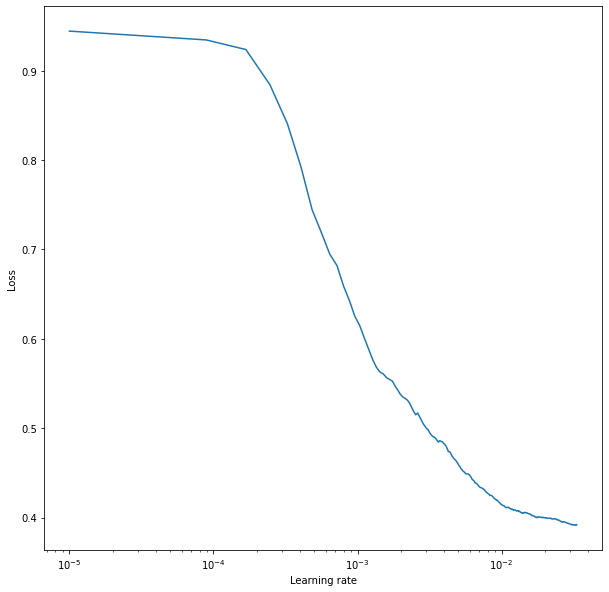

In [68]:
if use_lr_finder:
  model = compile_model(strategy, architecture, img_size, n_classes)
  lr_finder = LRFinder(min_lr=1e-5,
                      max_lr=1e-1,
                      steps_per_epoch=np.ceil(len(train_paths) // batch_size),
                      epochs=3)
  with strategy.scope():
    model.fit(dtrain, 
              batch_size=batch_size, 
              callbacks=[lr_finder], 
              steps_per_epoch=len(train_paths) // batch_size)

  lr_finder.plot_loss("")

#### Train

In [70]:
path = os.path.join("output_path", "single_model")
mkdir_if_not_exist(path)
model_path = os.path.join(path, f"{architecture}_model.h5")

schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-1,
                         steps_per_epoch=len(train_paths) // batch_size,
                         lr_decay=0.8,
                         cycle_length=5,
                         mult_factor=1.5)

lr_strategy=schedule if use_lr_strategy else None

callbacks = get_callbacks(model_path, lr_strategy)

with strategy.scope():
  model = compile_model(strategy, architecture, img_size, n_classes)
  history = model.fit(
          dtrain,
          validation_data=dvalid,
          epochs=epochs, 
          verbose=1,
          callbacks=callbacks,
          steps_per_epoch=len(train_paths) // batch_size,
          validation_steps=len(valid_paths) // batch_size)

  # summarize history
  plot_metric(history, 'loss', path)
  plot_metric(history, 'auc', path)

# To avoid timeout 
print("Avoiding timeout...")
while True:pass

Epoch 1/30
422/422 [==============================] - 375s 688ms/step - loss: 0.4500 - auc: 0.6639 - val_loss: 0.3224 - val_auc: 0.8166

Epoch 00001: val_loss improved from inf to 0.32244, saving model to output_path/single_model/EfficientNetB3_model.h5
Epoch 2/30
422/422 [==============================] - 223s 530ms/step - loss: 0.3305 - auc: 0.7927 - val_loss: 0.2934 - val_auc: 0.8542

Epoch 00002: val_loss improved from 0.32244 to 0.29345, saving model to output_path/single_model/EfficientNetB3_model.h5
Epoch 3/30
422/422 [==============================] - 224s 530ms/step - loss: 0.3030 - auc: 0.8268 - val_loss: 0.2780 - val_auc: 0.8706

Epoch 00003: val_loss improved from 0.29345 to 0.27800, saving model to output_path/single_model/EfficientNetB3_model.h5
Epoch 4/30
422/422 [==============================] - 224s 531ms/step - loss: 0.2889 - auc: 0.8461 - val_loss: 0.2681 - val_auc: 0.8884

Epoch 00004: val_loss improved from 0.27800 to 0.26809, saving model to output_path/single_mo

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download(model_path) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Predictions

In [39]:
with strategy.scope():
    model = tf.keras.models.load_model(model_path)

In [40]:
test_decoder = build_decoder(with_labels=False, target_size=(img_size, img_size))

df_sub = pd.read_csv("/content/sample_submission.csv")
test_paths = GCS_DS_PATH + "/test/" + df_sub['StudyInstanceUID'] + '.jpg'

dtest = build_dataset(
    test_paths, bsize=batch_size, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)
dtest

<PrefetchDataset shapes: (None, 512, 512, 3), types: tf.float32>

In [41]:
y_preds = model.predict(dtest, verbose=1)

28/28 [==============================] - 139s 5s/step


In [44]:
df_sub.iloc[:, 1:] = y_preds
display(df_sub)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.253799,0.441102,0.478454,0.508095,0.423665,0.349417,0.533085,0.464362,0.500012,0.381933,0.260536
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.255994,0.436030,0.465555,0.518697,0.428078,0.345336,0.554225,0.465799,0.506098,0.377595,0.263202
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.256956,0.441877,0.476766,0.512084,0.424241,0.351637,0.544233,0.466460,0.502161,0.379254,0.266821
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.256821,0.440772,0.477408,0.512535,0.426366,0.353544,0.541446,0.464080,0.502628,0.379626,0.264040
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.256760,0.434342,0.460439,0.521441,0.428363,0.340418,0.557184,0.468095,0.505815,0.377618,0.259492
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.81464483108873296584...,0.252293,0.438787,0.475710,0.507173,0.422309,0.352598,0.534458,0.461291,0.500576,0.382147,0.258369
3578,1.2.826.0.1.3680043.8.498.33579133018211530710...,0.253780,0.444222,0.478006,0.508406,0.419772,0.352463,0.530052,0.462306,0.498653,0.382876,0.258732
3579,1.2.826.0.1.3680043.8.498.61472811086105902907...,0.258140,0.435052,0.460538,0.527496,0.431458,0.339509,0.558110,0.468141,0.506973,0.377557,0.262330
3580,1.2.826.0.1.3680043.8.498.19434375795525494655...,0.251927,0.440295,0.479108,0.509454,0.421927,0.349863,0.540803,0.462769,0.499481,0.379147,0.258133


In [45]:
df_sub.to_csv('submission.csv',index=False)

#### TTA
A final technique that can raise accuracy by one percent or two is test time augmentation (TTA). This involves taking a series of different versions of the original image (for example cropping different areas, or changing the zoom) and passing them through the model. The average output is then calculated for the different versions and this is given as the final output score for the image.

In [46]:
# Test time augmentation rounds
TTA = 5
NUM_TESTING_IMAGES = df_sub.shape[0]
steps = TTA * ((NUM_TESTING_IMAGES / batch_size) + 1)

# Get the test dataset with tta to extract image
tta_dtest = build_tta(test_paths,
                      decode_fn=build_decoder(with_labels=False, 
                                              target_size=(img_size, img_size)),
                      augment_fn=build_augmenter(with_labels=False), 
                      bsize=batch_size, 
                      tta = True)

probabilities = model.predict(tta_dtest, steps = steps, verbose=1)[: TTA * NUM_TESTING_IMAGES]
probabilities = np.mean(probabilities.reshape((NUM_TESTING_IMAGES, TTA, n_classes), order = 'F'), axis = 1)

df_sub.iloc[:, 1:] = probabilities
display(df_sub)

144/144 [==============================] - 399s 3s/step


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.255492,0.441231,0.479562,0.508785,0.422199,0.355099,0.535019,0.464685,0.501465,0.381110,0.263842
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.255656,0.438022,0.470084,0.515232,0.425781,0.348571,0.546058,0.465694,0.504371,0.377977,0.261362
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.255642,0.442725,0.479771,0.505846,0.422957,0.356803,0.536313,0.464864,0.501024,0.380814,0.264883
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.251314,0.441273,0.476330,0.500989,0.416393,0.356189,0.527354,0.462797,0.499003,0.382821,0.258826
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.253769,0.436972,0.468469,0.515313,0.424818,0.345622,0.546173,0.464689,0.503031,0.379008,0.259366
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.81464483108873296584...,0.250567,0.437160,0.472188,0.506005,0.419889,0.351846,0.534447,0.462044,0.501525,0.380411,0.256710
3578,1.2.826.0.1.3680043.8.498.33579133018211530710...,0.250805,0.439303,0.472323,0.506188,0.418368,0.355383,0.531616,0.462497,0.501650,0.381872,0.258171
3579,1.2.826.0.1.3680043.8.498.61472811086105902907...,0.254941,0.431296,0.461398,0.522507,0.431749,0.344147,0.556812,0.466243,0.507212,0.375962,0.259422
3580,1.2.826.0.1.3680043.8.498.19434375795525494655...,0.250967,0.437938,0.470528,0.514071,0.421226,0.343142,0.543034,0.463454,0.501275,0.378796,0.257198


In [47]:
df_sub.to_csv('submission_tta.csv',index=False)

### Ensemble

#### Train

In [72]:
image_paths = paths[0:train_limit]
image_labels = labels[0:train_limit]

kf = IterativeStratification(n_splits=n_fold, order=1)

for fold in range(0, n_fold):

    print(f"\nFold: {fold}")

    path = os.path.join("output_path", str(fold))
    mkdir_if_not_exist(path)

    model_path = os.path.join(path, "model_"+str(fold)+".h5")

    result = next(kf.split(X=image_paths, y=image_labels), None)

    train = image_paths[result[0]].tolist()
    train_labels = [id_label_map[k] for k in train]
    val = image_paths[result[1]].tolist()
    valid_labels = [id_label_map[k] for k in val]

    print(f"train shape: {len(train)}")
    print(f"train steps_per_epoch: {len(train) // batch_size}")
    print(f"val shape: {len(val)}")
    print(f"validation steps_per_epoch: {len(val) // batch_size}")

    # Build the tensorflow datasets
    dtrain = build_dataset(
        train, train_labels, bsize=batch_size, decode_fn=decoder
    )

    dvalid = build_dataset(
        val, valid_labels, bsize=batch_size, 
        repeat=False, shuffle=False, augment=False, decode_fn=decoder
    )

    tf.keras.backend.clear_session()

    schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-1,
                         steps_per_epoch=np.ceil(len(train)/batch_size),
                         lr_decay=0.8,
                         cycle_length=5,
                         mult_factor=1.5)

    lr_strategy=schedule if use_lr_strategy else None


    callbacks = get_callbacks(model_path, lr_strategy)

    with strategy.scope():
      model = compile_model(strategy, architecture, img_size, n_classes)
      
      ###########
      # Training
      ###########

      history = model.fit(
          dtrain,
          validation_data=dvalid,
          epochs=epochs, verbose=1,
          callbacks=callbacks,
          steps_per_epoch=len(train) // batch_size,
          validation_steps=len(val) // batch_size)

      # summarize history
      plot_metric(history, 'loss', path)
      plot_metric(history, 'auc', path)
      
      # in order to release the memory
      del history
      del model
      gc.collect()

from google.colab import files

for fold in range(0, n_fold):
  print(f"downloading model_{fold}...")
  path = os.path.join("output_path", str(fold))
  mkdir_if_not_exist(path)
  model_path = os.path.join(path, "model_"+str(fold)+".h5")
  files.download(model_path) 

# To avoid timeout 
print("Avoiding timeout...")
while True:pass


Fold: 0
train shape: 24098
train steps_per_epoch: 376
val shape: 5985
validation steps_per_epoch: 93


UnavailableError: ignored

#### Predictions

In [ ]:
test_paths = GCS_DS_PATH + "test/" + df_sub['StudyInstanceUID'] + '.jpg'
test_paths[0]

'gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407atest/1.2.826.0.1.3680043.8.498.46923145579096002617106567297135160932.jpg'

In [ ]:
test_decoder = build_decoder(with_labels=False, target_size=(img_size, img_size))

dtest = build_dataset(
    test_paths[0:test_limit], bsize=batch_size, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)

ensemble_preds = np.zeros((len(test_paths[0:test_limit]), n_classes), dtype=np.float)

for fold in range(0, n_fold):
  print(f"model: {fold}")
  path = os.path.join("output_path", str(fold))
  mkdir_if_not_exist(path)
  model_path = os.path.join(path, "model_"+str(fold)+".h5")
  
  with strategy.scope():
      model = tf.keras.models.load_model(model_path)

      y_preds = model.predict(dtest, verbose=1)

      # sum the predicted values
      ensemble_preds += np.array(y_preds, dtype=np.float)

# average the predicted values
ensemble_preds /= n_fold
df_sub.iloc[:, 1:] = ensemble_preds
display(df_sub)

model: 0
56/56 [==============================] - 82s 1s/step
model: 1
56/56 [==============================] - 81s 1s/step
model: 2
56/56 [==============================] - 83s 1s/step
model: 3
56/56 [==============================] - 84s 1s/step
model: 4
56/56 [==============================] - 84s 1s/step


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.003980,0.148109,0.751670,0.006566,0.004812,0.017220,0.967534,0.034764,0.143648,0.961513,0.997017
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.000057,0.000110,0.000085,0.000170,0.000179,0.000255,0.000251,0.006026,0.005555,0.994002,0.000118
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.000219,0.000368,0.000274,0.000316,0.000569,0.000261,0.000327,0.028151,0.392895,0.643898,0.000217
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.003846,0.029073,0.049871,0.018470,0.013193,0.957945,0.039246,0.113185,0.254475,0.611831,0.019305
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.000273,0.000643,0.000559,0.000777,0.000815,0.000597,0.002610,0.050831,0.237322,0.804757,0.000424
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.81464483108873296584...,0.000549,0.001749,0.004719,0.008885,0.017725,0.926567,0.029308,0.006811,0.090162,0.958868,0.001191
3578,1.2.826.0.1.3680043.8.498.33579133018211530710...,0.000666,0.001067,0.002221,0.001579,0.003761,0.000356,0.002721,0.590587,0.351006,0.168774,0.001190
3579,1.2.826.0.1.3680043.8.498.61472811086105902907...,0.000064,0.000177,0.000101,0.000290,0.000317,0.000081,0.000221,0.006323,0.024265,0.967607,0.000125
3580,1.2.826.0.1.3680043.8.498.19434375795525494655...,0.000215,0.000629,0.000274,0.000299,0.000372,0.000051,0.000618,0.062418,0.274576,0.631775,0.000148


# References


1.   [RANZCR CLiP - Catheter and Line Position Challenge](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification)
2.   [CoroNet: A deep neural network for detection and diagnosis of COVID-19 from chest x-ray images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7274128/)
3.   [RANZCR TF RECORDS 768 STRATIFIED](https://www.kaggle.com/ragnar123/ranzcr-tf-records-768-stratified/code)


